<center><h2>ALTeGraD 2023<br>Lab Session 3: Transfer learning for NLP</h2> 24 / 10 / 2023<br> Dr. G. Shang, H. Abdine<br><br>

<hr>
<b>Ben Kabongo B.</b><br/>
MVA, ENS Paris-Saclay
<hr>

</center>

<br><br>
In this lab we will:
* Implement and pretrain a language model with transformer architecture.
* Use the pretrained model (transfer learning) to perform a sentiment analysis task which consists of classifying some books reviews into positive and negative ones.
* Compare the performance of the pretrained model to a model trained from scratch.
 <br>

<b>The deadline for this lab is October 31, 2023 11:59 PM.</b> More details about the submission and the architecture for this lab can be found in the handout PDF.

In [1]:
import math

import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### The Model

In [2]:
class TransformerModel(nn.Module):
    def __init__(self, ntokens, nhead, nhid, nlayers, dropout=0.5):
        super(TransformerModel, self).__init__()
        '''
        ntokens: the size of vocabulary
        nhid: the hidden dimension of the model.
        We assume that embedding_dim = nhid
        nlayers: the number of nn.TransformerEncoderLayer in nn.TransformerEncoder
        nhead: the number of heads in the multiheadattention models
        dropout: the dropout value
         '''
        self.model_type = "Transformer"
        self.encoder = nn.Embedding(num_embeddings=ntokens, embedding_dim=nhid)
        self.pos_encoder = PositionalEncoding(nhid)
        encoder_layers = nn.TransformerEncoderLayer(d_model=nhid, nhead=nhead, dim_feedforward=nhid, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer=encoder_layers, num_layers=nlayers)
        self.nhid = nhid
        self.init_weights()

    def generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = (
            mask.float()
            .masked_fill(mask == 0, float("-inf"))
            .masked_fill(mask == 1, float(0.0))
        )
        return mask

    def init_weights(self):
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src, src_mask):
        src = self.encoder(src) * math.sqrt(self.nhid)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, src_mask)
        return output


class ClassificationHead(nn.Module):
    def __init__(self, nhid, nclasses):
        super(ClassificationHead, self).__init__()
        self.decoder = nn.Linear(nhid, nclasses)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src):
        output = self.decoder(src)
        return output


class Model(nn.Module):
    def __init__(self, ntoken, nhead, nhid, nlayers, nclasses, dropout=0.5):
        super(Model, self).__init__()
        self.base = TransformerModel(ntokens=ntokens, nhead=nhead, nhid=nhid, nlayers=nlayers, dropout=dropout)
        self.classifier = ClassificationHead(nhid=nhid, nclasses=nclasses)

    def forward(self, src, src_mask):
        x = self.base(src, src_mask)
        output = self.classifier(x)
        return output

In [3]:
class PositionalEncoding(nn.Module):
    def __init__(self, nhid, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, nhid)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, nhid, 2).float() * (-math.log(10000.0) / nhid)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer("pe", pe)

    def forward(self, x):
        x = x + self.pe[: x.size(0), :]
        return self.dropout(x)

Let's verify if our model works, by applying one inference step

In [4]:
ntokens = 100 # the size of vocabulary
nhid = 200  # hidden dimension
nlayers = 4  # the number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 2  # the number of heads in the multiheadattention models
dropout = 0  # the dropout value

model = Model(ntokens, nhead, nhid, nlayers, ntokens, dropout).to(device)
dummy_input = torch.tensor([[2, 6, 2, 5, 43, 21]]).to(device)
src_mask = model.base.generate_square_subsequent_mask(1).to(device)
out = model.forward(dummy_input, src_mask)

print(out.shape) # is it the right shape?

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


torch.Size([1, 6, 100])


## Vocabulary and Tokenization

In [5]:
!wget https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/dict.txt
!head -5 dict.txt

--2023-10-24 18:31:17--  https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/dict.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 577587 (564K) [text/plain]
Saving to: ‘dict.txt’

dict.txt            100%[===================>] 564.05K  --.-KB/s    in 0.03s   

2023-10-24 18:31:17 (18.0 MB/s) - ‘dict.txt’ saved [577587/577587]

▁d 1
es 1
▁l 1
en 1
on 1


In [6]:
path_vocab = "dict.txt"
token2ind = {"<sos>": 0, "<pad>": 1, "<eos>": 2, "<oov>": 3} # the 4 first indices are reserved to special tokens
with open(path_vocab, "r") as f:
    for idx, line in enumerate(f):
        word = line.split()[0].strip()
        token2ind[word] =  idx + 4

ind2token = {v:k for k, v in token2ind.items()}

print(ind2token[1111])

▁trop


### Data Loader


In [7]:
import numpy
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset


class Dataset(Dataset):
    def __init__(
        self,
        path_documents,
        path_labels=None,
        token2ind={},
        max_len=512,
        task="language_modeling",
    ):
        self.task = task
        self.max_len = max_len
        self.token2ind = token2ind
        self.documents = []
        self.labels = []
        with open(path_documents, "r") as f1:
            for line in f1:
                self.documents.append(line.strip())
        if task == "classification":
            with open(path_labels, "r") as f1:
                for line in f1:
                    self.labels.append(int(line.strip()))
            assert len(self.labels) == len(self.documents)

    def __len__(self):
        return len(self.documents)

    def __getitem__(self, index):
        sequence = self.documents[index].split()
        if len(sequence) > self.max_len - 1:
            sequence = sequence[: self.max_len - 1]
        source_sequence = [self.token2ind["<sos>"]] + [
            self.token2ind.get(tok, self.token2ind["<oov>"]) for tok in sequence]
        if self.task == "language_modeling":
            target = source_sequence[1:]
            target.append(self.token2ind["<eos>"])
        elif self.task == "classification":
            target = [self.labels[index]]
        sample = {
            "source_sequence": torch.tensor(source_sequence),
            "target": torch.tensor(target),
        }
        return sample


def MyCollator(batch):
    source_sequences = pad_sequence(
        #we use padding to match the length of the sequences in the same batch
        [sample["source_sequence"] for sample in batch], padding_value=token2ind["<pad>"]
    )
    target = pad_sequence(
        [sample["target"] for sample in batch], padding_value=token2ind["<pad>"]
    )
    return source_sequences, target.reshape(-1)


def get_loader(
    path_documents,
    path_labels=None,
    token2ind={},
    max_len=512,
    batch_size=32,
    task="language_modeling",
):
    dataset = Dataset(
        path_documents,
        path_labels=path_labels,
        token2ind=token2ind,
        max_len=max_len,
        task=task,
    )
    data_loader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        shuffle=True,
        collate_fn=MyCollator,
        pin_memory=True,
        drop_last=True,
    )
    return data_loader

## The Training

In [8]:
def train(
    path_data_train,
    path_labels_train=None,
    path_data_valid=None,
    save_interval=-1,
    log_interval=5,
    task="language_modeling",
    batch_size=32,
):
    model.train()
    total_loss = 0.0
    ntokens = len(token2ind)
    data_loader = get_loader(
        path_data_train,
        path_labels_train,
        token2ind,
        task=task,
        batch_size=batch_size,
    )

    losses = []
    for idx, data in enumerate(data_loader): #step 1
        optimizer.zero_grad()
        src_mask = model.base.generate_square_subsequent_mask(data[0].size(0)).to(device)
        input = data[0].to(device)
        output = model(input, src_mask) #step 2
        if task == 'classification':
            #last vector only
            output = output[-1, :, :]
        output = output.view(-1, output.shape[-1])
        target =  data[1]
        target = target.to(device)
        loss = criterion(output, target)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5) # prevent exploding gradient
        optimizer.step()

        total_loss += loss.item()
        if idx % log_interval == 0 and idx > 0:
            cur_loss = total_loss / log_interval
            print(
                "| epoch {:3d} | {:5d}/{:5d} steps | "
                "loss {:5.5f} | ppl {:8.3f}".format(
                    epoch, idx, len(data_loader), cur_loss, math.exp(cur_loss),
                )
            )
            losses.append(cur_loss)
            total_loss = 0
    return losses

In [9]:
ntokens = len(token2ind) # the size of vocabulary
nhid = 200  # the dimension of the feedforward network model in nn.TransformerEncoder
nlayers = 4  # the number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 2  # the number of heads in the multiheadattention models
dropout = 0  # the dropout value

nclasses = 2 # for classification task only

model = Model(ntokens, nhead, nhid, nlayers, ntokens, dropout).to(device)

In [10]:
# optimization paramerters

criterion = nn.CrossEntropyLoss(ignore_index=token2ind['<pad>'])
lr = 0.0003  # learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [11]:
!wget https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/pretraining_subset.txt
path_data_train = "pretraining_subset.txt"

--2023-10-24 18:32:06--  https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/pretraining_subset.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10146460 (9.7M) [text/plain]
Saving to: ‘pretraining_subset.txt’

pretraining_subset. 100%[===================>]   9.68M  --.-KB/s    in 0.06s   

2023-10-24 18:32:06 (151 MB/s) - ‘pretraining_subset.txt’ saved [10146460/10146460]



In [12]:
#pretraining on a tiny subset
log_interval = 500
epochs = 2
for epoch in range(1, epochs + 1): #5
    train(
        path_data_train,
        save_interval=-1,
        task="language_modeling",
        batch_size=16,
        log_interval=log_interval,
    )

| epoch   1 |   500/ 3125 steps | loss 7.34613 | ppl 1550.181
| epoch   1 |  1000/ 3125 steps | loss 6.54457 | ppl  695.460
| epoch   1 |  1500/ 3125 steps | loss 6.25569 | ppl  520.968
| epoch   1 |  2000/ 3125 steps | loss 6.08383 | ppl  438.707
| epoch   1 |  2500/ 3125 steps | loss 5.96365 | ppl  389.026
| epoch   1 |  3000/ 3125 steps | loss 5.90083 | ppl  365.340
| epoch   2 |   500/ 3125 steps | loss 5.61190 | ppl  273.664
| epoch   2 |  1000/ 3125 steps | loss 5.54317 | ppl  255.488
| epoch   2 |  1500/ 3125 steps | loss 5.52931 | ppl  251.969
| epoch   2 |  2000/ 3125 steps | loss 5.51795 | ppl  249.124
| epoch   2 |  2500/ 3125 steps | loss 5.47068 | ppl  237.621
| epoch   2 |  3000/ 3125 steps | loss 5.45382 | ppl  233.649


## Text Generation


In [13]:
!wget https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/pretrained_model_4layers.pt

model = Model(ntokens, nhead, nhid, nlayers, ntokens).to(device)

#load the checkpoint
checkpoint = torch.load('pretrained_model_4layers.pt')
#load state dict
model.load_state_dict(checkpoint['model_state_dict'])

--2023-10-24 18:37:26--  https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/pretrained_model_4layers.pt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 88093955 (84M) [application/octet-stream]
Saving to: ‘pretrained_model_4layers.pt’

pretrained_model_4l 100%[===================>]  84.01M   269MB/s    in 0.3s    

2023-10-24 18:37:26 (269 MB/s) - ‘pretrained_model_4layers.pt’ saved [88093955/88093955]



/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


<All keys matched successfully>

In [14]:
!pip install sentencepiece   # uncomment this if you are using google colab
!wget https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/sentencepiece.french.model

import sentencepiece as spm

s = spm.SentencePieceProcessor(model_file='sentencepiece.french.model') #load sentencepiece model

#examples
encoded = s.encode_as_pieces("Bonjour les amis!")
decoded = s.decode_pieces(encoded)
print(encoded)
print(decoded)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 17.3 MB/s eta 0:00:00
--2023-10-24 18:37:42--  https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/sentencepiece.french.model
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115362 (1.1M) [application/octet-stream]
Saving to: ‘sentencepiece.french.model’

sentencepiece.frenc 100%[===================>]   1.06M  --.-KB/s    in 0.04s   

2023-10-24 18:37:42 (25.4 MB/s) - ‘sentencepiece.french.model’ saved [1115362/1115362]

['▁Bonjour', '▁les', '▁amis', '!']
Bonjour les amis!


In [38]:
def infer_next_token(sent):
    model.eval()
    sent_pieces = s.encode_as_pieces(sent)
    source = [token2ind['<sos>']] + [token2ind[el] for el in sent_pieces] # list of tokens
    source = torch.tensor(source).to(device)
    source = source.reshape(-1, 1)
    src_mask = model.base.generate_square_subsequent_mask(source.size(0)).to(device)
    out = model(source, src_mask)
    next_token_ind =  torch.argmax(torch.softmax(out, dim=2), dim=2)
    return int(next_token_ind[-1, 0]), out

def infer_next_tokens(sent, max_len=50):
    next_tokens = []
    for _ in range(max_len):
        next_token_ind, _ = infer_next_token(sent)
        tok = ind2token[next_token_ind]
        if tok == "<eos>":
            break
        next_tokens.append(tok)
        sent += " " + tok
    return next_tokens


In [39]:
sent = "Bonjour les"
print(infer_next_tokens(sent))

['▁gens', '▁qui', '▁ont', '▁été', '▁très', '▁accueillants', '▁et', '▁sympathiques', '.']


### Supervised task

In [40]:
!wget https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/cls-books/train.review.spm
!wget https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/cls-books/train.label
!wget https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/cls-books/test.review.spm
!wget https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/cls-books/test.label

path_data_train = "train.review.spm"
path_labels_train = "train.label"

path_data_valid = "test.review.spm"
path_labels_valid = "test.label"

--2023-10-24 18:56:32--  https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/cls-books/train.review.spm
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1495960 (1.4M) [text/plain]
Saving to: ‘train.review.spm’

train.review.spm    100%[===================>]   1.43M  --.-KB/s    in 0.04s   

2023-10-24 18:56:32 (40.7 MB/s) - ‘train.review.spm’ saved [1495960/1495960]

--2023-10-24 18:56:32--  https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/cls-books/train.label
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent,

In [51]:
# a function to evaluate the validation accuracy of the model.
def evaluate_accuracy(data_loader):
    model.eval()
    acc = 0.0
    n_samples = 0
    with torch.no_grad():
        for idx, data in enumerate(data_loader):
            src_mask = model.base.generate_square_subsequent_mask(data[0].size(0)).to(device)
            input = data[0].to(device)
            output = model(input, src_mask)
            output = output[-1, :, :]
            output = output.view(-1, output.shape[-1])
            target =  data[1]
            target = target.to(device)
            acc += (torch.argmax(output, dim=1) == target).sum().item()
            n_samples += len(target)
    return acc/n_samples

In [43]:
#save the base model to be loaded later in the fine-tuning phase
torch.save({"model_state_dict": model.base.state_dict(),}, "pretrained_model_4layers_no_class_head.pt")

In [53]:
from_scratch_settings = [True, False]

from_scratch_valid_acc = []
pretrained_valid_acc = []
lr = 0.0001

for from_scratch in from_scratch_settings:
    model = Model(ntokens, nhead, nhid, nlayers, 2, dropout).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    if not from_scratch:
        print("=====PRETRAINED MODEL======")
        #load checkpoint
        checkpoint = torch.load("pretrained_model_4layers_no_class_head.pt")
        #load state dict
        model.base.load_state_dict(checkpoint['model_state_dict'])
    else:
        print("=====Trainig FROM SCRATCH======")
    epochs = 15
    for epoch in range(1, epochs + 1):
        train(
            path_data_train,
            path_labels_train,
            save_interval=-1,
            task='classification',
            batch_size=8,
            log_interval=50,
        )
        acc = evaluate_accuracy(
            get_loader(
                path_data_valid,
                path_labels_valid,
                token2ind=token2ind,
                batch_size=20,
                task='classification',
            )
        )
        print("Acc :", acc)
        if from_scratch:
            from_scratch_valid_acc.append(acc)
        else:
            pretrained_valid_acc.append(acc)
    print()

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


=====Trainig FROM SCRATCH======
| epoch   1 |    50/  200 steps | loss 0.78580 | ppl    2.194
| epoch   1 |   100/  200 steps | loss 0.71916 | ppl    2.053
| epoch   1 |   150/  200 steps | loss 0.72233 | ppl    2.059
Acc : 0.5245
| epoch   2 |    50/  200 steps | loss 0.64923 | ppl    1.914
| epoch   2 |   100/  200 steps | loss 0.61317 | ppl    1.846
| epoch   2 |   150/  200 steps | loss 0.59013 | ppl    1.804
Acc : 0.6805
| epoch   3 |    50/  200 steps | loss 0.42802 | ppl    1.534
| epoch   3 |   100/  200 steps | loss 0.35907 | ppl    1.432
| epoch   3 |   150/  200 steps | loss 0.41734 | ppl    1.518
Acc : 0.743
| epoch   4 |    50/  200 steps | loss 0.25329 | ppl    1.288
| epoch   4 |   100/  200 steps | loss 0.17583 | ppl    1.192
| epoch   4 |   150/  200 steps | loss 0.12011 | ppl    1.128
Acc : 0.7475
| epoch   5 |    50/  200 steps | loss 0.07367 | ppl    1.076
| epoch   5 |   100/  200 steps | loss 0.04129 | ppl    1.042
| epoch   5 |   150/  200 steps | loss 0.20064 | 

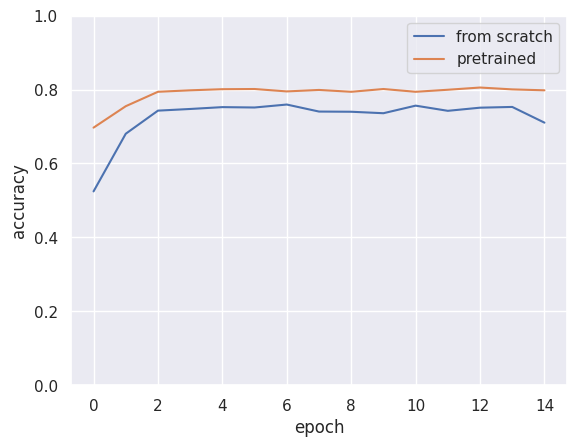

In [56]:
#Visualize the accuracy
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

plt.plot(from_scratch_valid_acc, label="from scratch")
plt.plot(pretrained_valid_acc, label="pretrained")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.ylim(0, 1)
plt.legend()
plt.show()
